In [1]:
import numpy as np
import gym

import collections
import random
import cv2

import tensorflow as tf
import keras
from keras.models import Model
from keras import layers
from keras import backend as K
from keras import optimizers

import pickle

2024-03-14 09:08:16.244926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 09:08:16.245041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 09:08:16.519209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic_part = tf.minimum(abs_error, delta)
    linear_part = abs_error - quadratic_part
    loss = 0.5 * quadratic_part**2 + delta * linear_part
    return tf.reduce_mean(loss)

In [3]:
class CarAgent:
    def __init__(self, env):
        self.env = env
        self.num_actions = 3
        self.epsilon = 1                               # Probability of taking a random action
        self.epsilon_min = 0.1                         # Minimum epsilon value after complete decay
        self.decay_factor = 0.000018                   # Factor by which epsilon is decayed after each episode (epsilon annealing)
        self.discount_factor = 0.99                    # Factor by which future rewards are discounted
        self.memory = collections.deque(maxlen=200000) # Memory to store experience. Max = 200000
        self.learning_rate = 0.00025                   # Learning rate for the Neural network
        self.image_width = 150                         # Input image width
        self.image_height = 100                        # Input image height
        self.stack_depth = 4                           # Number of image samples to stack
        self.model = self.create_CNN_model()           # Initialize the Neural network
        self.target_model = self.create_CNN_model()    # Initialize a target model
        self.update_target_weights()                   # Initialize the target weights the same as
                                                         #those of the learning model


    def create_CNN_model(self):

        input_shape = (self.stack_depth, self.image_height, self.image_width)
        actions_input = layers.Input((self.num_actions,), name = 'action_mask')

        frames_input = layers.Input(input_shape, name='input_layer')
        conv_1 = layers.Conv2D(32, (8,8), strides=4, padding ='same'\
        ,activation = 'relu', name='conv_1',kernel_initializer='glorot_uniform',bias_initializer='zeros')(frames_input)

        conv_2 = layers.Conv2D(64, (4,4), strides=2, padding='same', activation='relu',name='conv_2'\
           ,kernel_initializer='glorot_uniform',bias_initializer='zeros')(conv_1)

        conv_3 = layers.Conv2D(64, (3,3), strides=1, padding='same',name='conv_3', activation='relu'\
           ,kernel_initializer='glorot_uniform',bias_initializer='zeros')(conv_2)

        flatten_1 = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(512, activation='relu', name='dense_1',
            kernel_initializer='glorot_uniform',bias_initializer='zeros')(flatten_1)
        output = layers.Dense(self.num_actions, activation='linear', name='output',
            kernel_initializer='glorot_uniform',bias_initializer='zeros')(dense_1)
        masked_output = layers.Multiply(name='masked_output')([output, actions_input])

        model = Model(inputs=[frames_input, actions_input], outputs=[masked_output])

        optimizer = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer, loss=huber_loss)

        return model

    def huber_loss(self,y, q_value):

        # Got huber loss code online but found it in Tensor flow later
        error = K.abs(y - q_value)
        quadratic_part = K.clip(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = K.mean(0.5 * K.square(quadratic_part) + linear_part)
        return loss

    def update_target_weights(self):
        # Update target network weights with the weights of the model being learnt
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, current_state, action, reward, next_state, done):
        # Push an experience sample to the replay memory
        self.memory.append([current_state, action, reward, next_state, done])

    def process_image(self, image):
        # Simple processing: RGB to GRAY and resizing keeping a fixed aspect ratio
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        image = cv2.resize(image, (self.image_width, self.image_height))

        return image

    def greedy_action(self, current_state):
        # choose action according to an epsilon-greedy policy
        current_state = np.float32(np.true_divide(current_state,255))
        action_mask = np.ones((1, self.num_actions))
        q_values = self.model.predict([current_state, action_mask])[0]
        greedy_action = np.argmax(q_values)

        return greedy_action

    def calculate_targets(self, batch_size):

        #Initilize a List for each data type in a given sample
        current_states = []
        rewards = []
        actions = []
        next_states = []
        dones = []

        #extract all the required data from each batch
        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, next_state, done = sample
            current_states.append(state)
            rewards.append(reward)
            actions.append(action)
            next_states.append(next_state)
            dones.append(done)

        #Convert back to array.
        # When we stored image data in replay memory it wasn't normalized and was of type uint8.
        # This takes up less memory space. Just before training the network with this data
        #we normalize it and convert it to float32 type.

        current_states = np.array(current_states)
        current_states = np.float32(np.true_divide(current_states,255))

        next_states = np.array(next_states)
        next_states = np.float32(np.true_divide(next_states,255))

        #This action mask is simply a vector of ones to pass to the the target network while making prediction
        #This is because while selecting the best action in the next state we need the Q-values
        #of all the actions and then select the one with the maximu q-value and this is the reason we multiply
        #all the q-values with 1. This is just a requirement with converning the architecture of our CNN
        #because it takes as input both the state and an action mask.
        action_mask = np.ones((1,self.num_actions))

        #Make a mask for all the samples in the batch
        action_mask = np.repeat(action_mask, batch_size, axis=0)

        #Predict the q-values of all the actions in the next state using the target model
        next_Q_values = self.target_model.predict([next_states, action_mask])

        #If the next state is the terminal state the q-value is zero. This is how the mountain car
        #problem hs been defined
        next_Q_values[dones] = 0

        #Calulate the Bellman target using the Bellman equation
        targets = rewards + self.discount_factor * np.max(next_Q_values, axis=1)

        #This action mask encodes your target value in a one-hot fashion so as to easily subtract
        #the two values while calculating the Bellman error.
        action_mask_current = self.get_one_hot(actions)

        return current_states, action_mask_current, targets

    def get_one_hot(self,actions):

        #one hot encode function. Calculates an action mask for you according to the action that was
        #taken in the current state to move to the next state
        actions = np.array(actions)
        one_hots = np.zeros((len(actions), self.num_actions))

        one_hots[:, 0][np.where(actions == 0)] = 1
        one_hots[:,1][np.where(actions == 1)] = 1
        one_hots[:, 2][np.where(actions == 2)] = 1

        return one_hots

    def train_from_experience(self, states, action_mask, targets ):

        # Train your model using a batch of samples from the replay memory
        # Both keras functions : model.fit and model.train_from_batch work the same
        # Either of them can be used

        # self.model.fit([states, action_mask], action_mask * targets[:, None], epochs=1, verbose=0)

        #Labels are calculated by multiplying the action mask with the target value for each sample
        #This technique simply allows us to encode the target in a one hot fashion but instead of a '1'
        #at the desired position we have the actual target value.

        #This helps us to subtract the correct values while calulating the bellman error.
        # As an example, imagine you took action '2' in a certain state and the next best action in the
        #next state is the action '1'. According to the Bellman error you need to subtract the Q-Value of
        #action '2' given by the learning model from the Q-Value of action '1' given by the target model.
        # How do you subtract these values since they are located at different indexes?

        #You do precisely this.
        labels = action_mask * targets[:, None]

        #Model.train_on_batch will first make a prediction using the current state and encode the output
        #in a one-hot fashion but with the q-value of the action as the hot entry instead of a '1'.
        #It will then calculate the loss using the predition and the given label and update the Network's
        #Weights accordingly.
        loss = self.model.train_on_batch([states, action_mask], labels)

    def save_model(self,name):
        self.model.save(name)


In [4]:
# gym.make('CartPole-v1').env allows you to remove the upper limit on the number of iterations
#in an episode
env = gym.make('CartPole-v1', render_mode="rgb_array").env

#Initialize your car agent with its replay memory and CNN model
agent = CarAgent(env)

#Number of frames to stack to make up one state
stack_depth = 4

#Buffer memory to collect and stack a number of frames to form a single state. In my case,
#I stack up frames as mentioned in the DQN paper
seq_memory = collections.deque(maxlen=stack_depth)

#The done Flag tells us if the episode was completed by reaching the target
done = False

#The training flag tells the agent when to start training the CNN model
training = False

#The number of random samples to use for one training epoch
batch_size = 32

#This is the number of episodes after which I copy the weights of my learning model to the target model
#In the original DQN implementation this value is calculated as the number of frames.
#Adjust this value according to the number of frames you use for each episode.
#In my case the number of frames  = 35 * time steps
update_threshold = 35

#This value saves my model, it's weights and the episode rewards each save_threshold episodes. I
#use the saved data to analyze my training progress
save_threshold = 1000

#Number of episodes to train for
episodes = 9700 # 1000001

#Max number of steps for each epsiode. We define this because we have removed the upper limit on the
#number of steps in each episode
time_steps = 300

#Save this many random samples before training starts0
collect_experience = agent.memory.maxlen - 50000

#Calculate a new action every frame_skip frames
frame_skip = 4

#List varibale to save the reward for each each episode
ep_reward = []

In [5]:
pip install gym[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
step_rewards = []

#Loop for the number of episodes
for episode in range(1,episodes):

    #At the beginning of each new episode the first state is just formed by staking up
    #the same frame 4 times and saving it bufer
    seq_memory.clear()
    initial_state = env.reset()
    current_image = env.render()
    frame = agent.process_image(current_image)
    frame = frame.reshape(1, frame.shape[0], frame.shape[1])
    current_state = np.repeat(frame, stack_depth, axis=0)
    seq_memory.extend(current_state)

    #The episode reward is set to zero at the beginning of each new episode
    episode_reward = 0
    for time in range(time_steps):

        #Calcualte a new action every 4 frames
        if time % frame_skip == 0:
            if training:
                #Decay epsilon each frame. I decay epsilon only when I calculate a new action
                #and only if I am trainig
                agent.epsilon = agent.epsilon - agent.decay_factor
                agent.epsilon = max(agent.epsilon_min, agent.epsilon)

            # Calculate an epsilon-greedy action
            if np.random.rand() <= agent.epsilon:
                # action = np.int(np.random.choice([0,2],1))
                action = env.action_space.sample()
            else:
                #reshaping my current state so that it fits the dimension required to input to the
                #CNN
                action = agent.greedy_action(current_state.reshape(1, current_state.shape[0]\
                                   , current_state.shape[1], current_state.shape[2]))

        #Take the new action or repeat the previous one if a new one is not calculated
        # Perform the step
        step_result = env.step(action)

        # Check the length of the result tuple
        if len(step_result) >= 4:
            next_pos, reward, done, _ = step_result[:4]  # Unpack the first four elements
        else:
            # Handle the case when the result tuple doesn't contain enough elements
            # Adjust the number of elements accordingly based on your environment
            print("Warning: Unexpected number of elements returned by env.step().")
            print("Adjusting the unpacking accordingly.")
            next_pos, reward, done, _ = step_result  # Unpack all available elements


        #Collect, process and store the new frame in the buffer
        next_frame = env.render()
        next_frame = agent.process_image(next_frame)
        seq_memory.append(next_frame)

        #At any given moment we have 4 frames stored in the buffer. The buffer is FIFO type so each new
        #frame that is appended pushes out the oldest one. This way we calculate our next state as the
        #4 most recent frames after taking an action (either greedy or random)
        next_state = np.asarray(seq_memory)
        agent.memory.append([current_state, action, reward, next_state, done])

        #set current state as the next state. Current state is used to calculate the new geedy action
        current_state = next_state

        #If the replay memory has a minimum number of experience samples, start training the network
        if len(agent.memory) == collect_experience:
            training = True
            print('Start training')

        #The actual training command. First calculate the targets for each batch and the action mask
        #corresponding to the action, then update the model weights based on the bellman error
        if training:
            states, action_mask, targets = agent.calculate_targets(batch_size)
            agent.train_from_experience(states,action_mask, targets)

        #Add the reward for each step to the episode reward
        episode_reward = episode_reward + reward

        #If the epsiode reaches the terminal state before max number of allowed steps, break the for loop
        if done:
            break
        step_rewards.append(episode_reward)

    #Keeping track of the total episode reward for each episode
    ep_reward.append([episode, episode_reward])

#     Print episode information after each episode
    if(episode % 1000 == 0):
        print("episode: {}/{}, epsilon: {}, episode reward: {}".format(episode, episodes, agent.epsilon, episode_reward))

    #Update target weights each update_threshold episodes
    if training and (episode % update_threshold) == 0:
#         print('Weights updated at epsisode:', episode)
        agent.update_target_weights()

#     #Saving the model architecture, it's weights and total episode rewards each save_threshold episodes
#     if training and (episode%save_threshold) == 0:
# #         print('Data saved at epsisode:', episode)
# #         agent.save_model('./train/DQN_CNN_model_{}.h5'.format(episode))
#         pickle.dump(ep_reward, open('./train/rewards_{}.dump'.format(episode), 'wb'))

print('Data saved at epsisode:', episode)
# agent.save_model('./train/DQN_CNN_model_{}.h5'.format(episode))
pickle.dump(ep_reward, open('./rewards_{}.dump'.format(episode), 'wb'))

env.close()

/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 1000/9700, epsilon: 1, episode reward: 17.0
episode: 2000/9700, epsilon: 1, episode reward: 9.0
episode: 3000/9700, epsilon: 1, episode reward: 54.0
episode: 4000/9700, epsilon: 1, episode reward: 21.0
episode: 5000/9700, epsilon: 1, episode reward: 16.0
episode: 6000/9700, epsilon: 1, episode reward: 10.0
episode: 7000/9700, epsilon: 1, episode reward: 16.0
episode: 8000/9700, epsilon: 1, episode reward: 18.0
episode: 9000/9700, epsilon: 1, episode reward: 10.0
Data saved at epsisode: 9699


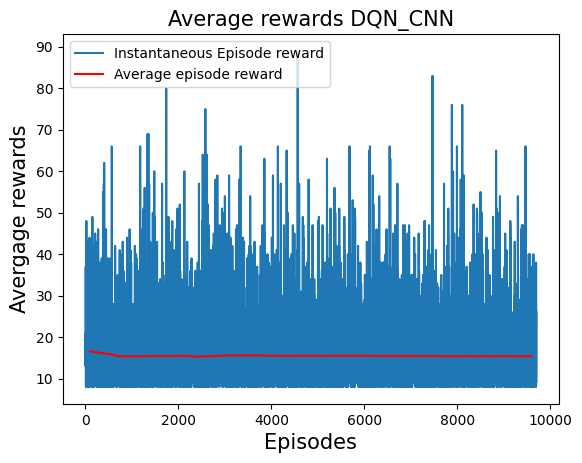

In [7]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

temp = '/kaggle/working/rewards_' + str(episodes - 1) + '.dump'
rewards = np.asarray(pickle.load(open(temp, 'rb')))
avg_rewards = []
cal_mean = 100

for i in range (1, len(rewards)):
    if i%cal_mean == 0:
        avg_rewards.append([i, np.mean(rewards[:i,1])])

avg_rewards = np.asarray(avg_rewards)

plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)

plt.plot(rewards[:,0],rewards[:,1], label = 'Instantaneous Episode reward')
plt.plot(avg_rewards[:,0], avg_rewards[:,1],'red',label = 'Average episode reward')
plt.legend(loc='best')
# plt.xlim([0,episodes + 1])
# plt.ylim([0,100])
plt.xlabel('Episodes')
plt.ylabel('Avergage rewards')
plt.title('Average rewards DQN_CNN')

plt.show()

In [8]:
# rewards